# Homework 4: Parallelism

### Due Monday March 5, 2018 @ 2pm

For this homework you will run the same algorithm under different parallelization methods and evaluate the speedups (execution time). You will compare simple serial (no parallelization), multiprocessing (or concurrent.futures), and ipyparallel module (or dask, if you like).


The algorithm uses a Monte Carlo dart-throwing simulation to calculate a numerical approximation to Pi. A simple Python version of this program is on the next slide to show how it can be implemented without parallelization. It is deliberately not copy- pastable so that you have to read it and (hopefully) understand it.


- Write a program that runs this algorithm under the three different parallelization methods. 
- Run several trials with different numbers of darts thrown (up to execution times ~100 seconds).
- Keep track of the execution times as a function of number of darts and method of parallelization. 
- Keep track of the simulation rate (darts thrown per second). 
- Plot execution time and simulation rate as a function of number of darts for all three methods. (If you calculated standard deviations, use errorbar plots.)
- In your README file, explain the behavior you measure and illustrate in the plot.
- If you want to be awesome (!), you can run each simulation multiple times for each number of darts and calculate the standard deviation for the execution time and the simulation rate, but this is not required.


We would compare the performances and execution times of following three methods of the same algorithm -  approximating the $\pi$ value by running a Monte Carlo dart-throwing simulation.
- Serial
- multiprocessing
- ipyparallel

In [1]:
# Import necessary libraries for running all three methods
import multiprocessing as mp
from multiprocessing import Pool 
import ipyparallel as ipp
from ipyparallel import Client
from random import uniform
from time import time

First and foremost, before running any algorithm, we need to define a function "dart_throw" that throws a number of darts (n) and returns the number of darts (m) that land inside the inscribed circle.

In [2]:
# Throw n darts in [0, 1] * [0, 1] square
# Return m darts inside the unit circle
def dart_throw(n):
    m = 0
    for i in range(int(n)):
        x, y = uniform(0, 1), uniform(0, 1)
        if x**2 + y**2 < 1:
            m += 1
    return m

## Serial Approach

To run the algorithm in serial, we define a function that takes a given input number of darts $n$ to throw and returns the final approximation of $\pi$ value.

In [3]:
# Throw n darts in [0, 1] * [0, 1] square
# Returns approximated pi-value in monte-carlo simulation and execution time
def pi_serial(n):
    """
    Naive serial method of monte carlo pi using dart_throw function.
    """
    t1 = time()
    m = dart_throw(n)
    pi_approx = 4. * m / n
    
    t2 = time()
    t_loop = t2 - t1
    
    return pi_approx, t_loop

In [4]:
# Test with 1,000,000 darts
import os
print("Number of cpu cores on this machine is : "+ str(os.cpu_count()))
%time pi_serial(1000000)

Number of cpu cores on this machine is : 8
CPU times: user 703 ms, sys: 5.95 ms, total: 709 ms
Wall time: 706 ms


(3.145852, 0.7057299613952637)

## Multiprocessing Approach

To run the algorithm using python multiprocessing, we define a function that takes a given input number of darts $n$ to throw and number of workers/cores to work/assign, then returns the final approximation of $\pi$ value and execution time.

In [5]:
# Throw n darts in [0, 1] * [0, 1] square
# Can manually select how many workers/cores to work with, by setting n_proc = x
# Returns approximated pi-value in monte-carlo simulation and execution time
def pi_mp(n, n_proc = None, t_break = True):
    """
    Calculate pi using python multiprocessing
    
    Note: 
    ----------
    n_proc: Number of workers/cores to work with, default = os.cpu_count()
    t_break: Breakdown of the total time spent
    t_loop: Time spent in monte carlo simulation in seconds.
            Time to initialize and shut down worker pool have been excluded. 
    """
    # default number processes = num of CPUs
    if not n_proc:
        import os
        n_proc = os.cpu_count()    
    
    # t1 - starting time
    t1 = time()
    
    # average workload of each worker/core (number of darts that each worker/core processes)
    avg_load = n // n_proc
    extra_load = n % avg_load
    
    # initialize workload for workers/cores
    min_load = [avg_load] * n_proc
    min_load[n_proc - 1] += extra_load
    
    # start a pool of workers
    pool = Pool(processes=n_proc)

    # t2 - time for workers/cores to start processing
    t2 = time()
    
    # assign workloads to each worker
    results = pool.imap_unordered(dart_throw, min_load)
    # combine results from all workers
    n_in_cirlce = sum(results)
    
    # t3 - time when all processings finished
    t3 = time()
    
    # shut down pool, remove pointer to pool object, collect garbage, and release memory
    pool.terminate()
    del pool
    
    # Calculate the approximated pi-value
    pi_approx = 4 *  n_in_cirlce / n    

    # t4 - all work done
    t4 = time()
    
    t_setup = t2-t1
    t_loop = t3-t2
    t_shutdown = t4-t3
    
    if t_break:
        print("set up {0} workers used {1:.3g}s".format(n_proc, t_setup))
        print("throwing {0} darts used {1:.3g}s".format(n, t_loop))
        print("terminate {0} workers used {1:.3g}s".format(n_proc, t_shutdown))
    return pi_approx, t_loop

In [6]:
# Test with 1,000,000 darts
import os
print("Number of cpu cores on this machine is : "+ str(os.cpu_count()))
%time pi_mp(1000000)

Number of cpu cores on this machine is : 8
set up 8 workers used 0.0401s
throwing 1000000 darts used 0.185s
terminate 8 workers used 0.03s
CPU times: user 15.7 ms, sys: 39.7 ms, total: 55.4 ms
Wall time: 256 ms


(3.139556, 0.18474984169006348)

## Ipyparallel Approach

To run the algorithm using ipyparallel, similar to using multiprocessing, we define a function that takes a given input number of darts $n$ to throw, then returns the final approximation of $\pi$ value and execution time.

First start ipython cluster by running

<center> $ipcluster start -n (number of processers) </center>


In [7]:
# To run terminal command in python, we use os.popen
import os
cluster_starting_command = "ipcluster start -n "+ str(os.cpu_count())
os.popen(cluster_starting_command)

In [8]:
# Throw n darts in [0, 1] * [0, 1] square
# Returns approximated pi-value in monte-carlo simulation and execution time
def pi_ipp(n, t_break = True):
    """
    Calculate pi using ipyparallel module
    
    NOTE
    ----------
    t_break: Breakdown of the total time spent
    t_loop: Time spent in monte carlo simulation in seconds.
            Time to initialize ipyparallel client has been excluded.   
    """
    # Initialize an IPyparallel client
    # clients = Client() # Initialize outside to avoid opening too many files
    n_proc = len(clients.ids)
    
    # t1 - starting time
    t1 = time()
    
    # average workload of each worker (number of darts that each worker processes)
    avg_load = n // n_proc
    extra_load = n % avg_load
    
    # initialize workload for workers
    min_load = [avg_load] * n_proc
    min_load[n_proc - 1] += extra_load
    
    # t2 - time to start processing
    t2 = time()
    
    # Create a DirectView object
    d_view = clients.direct_view()
    with d_view.sync_imports():
        from random import uniform
    results = d_view.map_async(dart_throw, min_load)
    
    # Calculate the approximated pi-value
    pi_approx = 4 * sum(results) / n
    
    # t3 - all work done
    t3 = time() 
    
    t_loop = t3 - t2
    t_setup = t2 - t1
    
    if t_break:
        print("set up {0} ipyparallel engines used {1:.3g}s".format(n_proc, t_setup))
        print("throwing {0} darts used {1:.3g}s".format(n, t_loop))
    return pi_approx, t_loop

In [9]:
# Test with 1,000,000 darts
clients = Client() # Initialize outside to avoid opening too many files
import os
print("Number of cpu cores on this machine is : "+ str(os.cpu_count()))
%time pi_ipp(1000000)

Number of cpu cores on this machine is : 8
importing uniform from random on engine(s)
set up 8 ipyparallel engines used 1.91e-06s
throwing 1000000 darts used 0.344s
CPU times: user 75.9 ms, sys: 37.2 ms, total: 113 ms
Wall time: 344 ms


(3.143576, 0.3436579704284668)

## Performances

To see how the performances of different parallelization methods vary, we iterate the methods through different values of n, times the algorithm's performance with each method of parallelization, and returns the total run time and run time per "dart throw".

In [10]:
# First import necessary libraries for plotting
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [11]:
n_benchmark = [1e1, 3e1, 1e2, 3e2, 1e3, 3e3, 1e4, 3e4, 1e5, 3e5, 1e6, 3e6, 1e7]

In [12]:
t_serial = [pi_serial(n)[1] for n in n_benchmark] # Iterate Serial approach through benchmark values

In [13]:
t_mp = [pi_mp(n)[1] for n in n_benchmark] # Iterate Multiprocessing approach through benchmark values

set up 8 workers used 0.0331s
throwing 10.0 darts used 0.00263s
terminate 8 workers used 0.106s
set up 8 workers used 0.0313s
throwing 30.0 darts used 0.00287s
terminate 8 workers used 0.103s
set up 8 workers used 0.0325s
throwing 100.0 darts used 0.00309s
terminate 8 workers used 0.105s
set up 8 workers used 0.0323s
throwing 300.0 darts used 0.00303s
terminate 8 workers used 0.106s
set up 8 workers used 0.0312s
throwing 1000.0 darts used 0.00334s
terminate 8 workers used 0.106s
set up 8 workers used 0.0323s
throwing 3000.0 darts used 0.0039s
terminate 8 workers used 0.102s
set up 8 workers used 0.0323s
throwing 10000.0 darts used 0.00717s
terminate 8 workers used 0.103s
set up 8 workers used 0.0313s
throwing 30000.0 darts used 0.0121s
terminate 8 workers used 0.0998s
set up 8 workers used 0.0319s
throwing 100000.0 darts used 0.0255s
terminate 8 workers used 0.0801s
set up 8 workers used 0.039s
throwing 300000.0 darts used 0.0627s
terminate 8 workers used 0.0445s
set up 8 workers used 

In [14]:
clients = Client() # Initialize outside to avoid opening too many files
t_ipp = [pi_ipp(n)[1] for n in n_benchmark] # Iterate Ipyparallel module through benchmark values

importing uniform from random on engine(s)
set up 8 ipyparallel engines used 3.1e-06s
throwing 10.0 darts used 0.0675s
importing uniform from random on engine(s)
set up 8 ipyparallel engines used 3.1e-06s
throwing 30.0 darts used 0.0498s
importing uniform from random on engine(s)
set up 8 ipyparallel engines used 1.91e-06s
throwing 100.0 darts used 0.0512s
importing uniform from random on engine(s)
set up 8 ipyparallel engines used 1.91e-06s
throwing 300.0 darts used 0.0557s
importing uniform from random on engine(s)
set up 8 ipyparallel engines used 2.86e-06s
throwing 1000.0 darts used 0.0556s
importing uniform from random on engine(s)
set up 8 ipyparallel engines used 2.15e-06s
throwing 3000.0 darts used 0.0488s
importing uniform from random on engine(s)
set up 8 ipyparallel engines used 1.91e-06s
throwing 10000.0 darts used 0.0499s
importing uniform from random on engine(s)
set up 8 ipyparallel engines used 1.91e-06s
throwing 30000.0 darts used 0.0566s
importing uniform from random 

Processor Type: Macbook Pro with 2.9 GHz Intel Core i7, 4 Cores


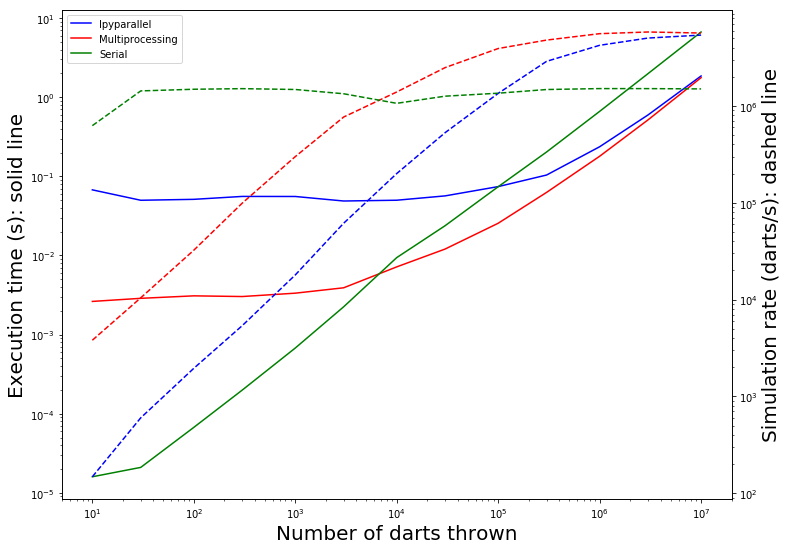

In [15]:
print("Processor Type: Macbook Pro with 2.9 GHz Intel Core i7, 4 Cores")
fs = 20
f1, ax1= plt.subplots(figsize = [12, 9])
ax1.plot(n_benchmark, t_ipp, label = 'Ipyparallel', color = 'blue')
ax1.plot(n_benchmark, t_mp, label = 'Multiprocessing', color = 'red')
ax1.plot(n_benchmark, t_serial, label = 'Serial', color = 'green')

ax1.set_yscale('log')
ax1.set_xscale('log')
plt.legend(loc = 'best')
ax1.set_xlabel('Number of darts thrown', fontsize = fs)
ax1.set_ylabel('Execution time (s): solid line', fontsize = fs)

ax2 = ax1.twinx()
n_bm_np = np.array(n_benchmark)
ax2.plot(n_benchmark, n_bm_np/np.array(t_ipp), '--', color = 'blue')
ax2.plot(n_benchmark, n_bm_np/np.array(t_mp), '--', color = 'red')
ax2.plot(n_benchmark, n_bm_np/np.array(t_serial), '--', color = 'green')

ax2.set_yscale('log')
ax2.set_xscale('log')

ax2.set_ylabel('Simulation rate (darts/s): dashed line', fontsize = fs)
plt.show()

In [16]:
f1.savefig('Performances.png', dpi = 300) # Save the plot for further references